In [1]:
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=f'content/YOLO_detection/yolo_detection/weights/best_saved_model/best_float16.tflite')
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
import cv2

class LetterBox:
    """Resize image and padding for detection, instance segmentation, pose."""

    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, stride=32):
        """Initialize LetterBox object with specific parameters."""
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride

    def __call__(self, labels=None, image=None):
        """Return updated labels and image with added border."""
        if labels is None:
            labels = {}
        img = labels.get('img') if image is None else image
        shape = img.shape[:2]  # current shape [height, width]
        new_shape = labels.pop('rect_shape', self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        ratio = r, r  # width, height ratios
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:  # minimum rectangle
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:  # stretch
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        dw /= 2  # divide padding into 2 sides
        dh /= 2
        if labels.get('ratio_pad'):
            labels['ratio_pad'] = (labels['ratio_pad'], (dw, dh))  # for evaluation

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                 value=(114, 114, 114))  # add border

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels['img'] = img
            labels['resized_shape'] = new_shape
            return labels
        else:
            return img

In [8]:
image_path = "dataset/test/images/IMG_7723_jpg.rf.07662daea0eaaaf605094fcc1f340675.jpg"

im = [LetterBox(256, auto=False, stride=32)(image=cv2.imread(image_path))]

In [9]:
import numpy as np

im = np.stack(im)
print(im.shape)
im = im[..., ::-1].transpose((0, 1, 2, 3))  # BGR to RGB, BHWC to BCHW, (n, 3, h, w)
print(im.shape)
im = np.ascontiguousarray(im)  # contiguous
im = im.astype(np.float32)

(1, 256, 256, 3)
(1, 256, 256, 3)


In [10]:
im /= 255

In [11]:
# Step 3: Allocate input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [12]:
# Step 4: Prepare the input tensor
input_data = im
interpreter.set_tensor(input_details[0]['index'], input_data)

In [13]:
# Step 5: Run inference
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [14]:
# Process the output_data as needed
print(output_data.shape)

(1, 5, 1344)


In [15]:
import numpy as np

nc = 0
conf_thres = 0.25

bs = output_data.shape[0]  # batch size
nc = nc or (output_data.shape[1] - 4)  # number of classes
nm = output_data.shape[1] - nc - 4
mi = 4 + nc  # mask start index
xc = np.amax(output_data[:, 4:mi], 1) > conf_thres  # candidates

In [16]:
multi_label=False
multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)

In [17]:
prediction = np.transpose(output_data, (0, -1, -2))

In [18]:
prediction.shape

(1, 1344, 5)

In [19]:
def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
        y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [20]:
prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy

In [21]:
output = [np.zeros((0, 6 + nm))] * bs

In [22]:
import cv2

max_nms=30000
agnostic=False
max_wh=7680
iou_thres = 0.45
max_det = 300

for xi, x in enumerate(prediction):  # image index, image inference
  x = x[xc[xi]]  # confidence

  if not x.shape[0]:
    continue

  # Detections matrix nx6 (xyxy, conf, cls)
  box = x[:, :4]
  cls = x[:, 4:4+nc]
  mask = x[:, 4+nc:4+nc+nm]

  conf = np.max(cls, axis=1, keepdims=True)
  j = np.argmax(cls, axis=1, keepdims=True)

  # Concatenate the arrays along axis 1
  x = np.concatenate((box, conf, j.astype(float), mask), axis=1)

  # Reshape conf to a 1-dimensional array
  conf_flat = conf.flatten()

  # Filter the resulting array based on the condition conf_flat > conf_thres
  filtered_x = x[conf_flat > conf_thres]

  n = filtered_x.shape[0]  # number of boxes

  if not n:  # no boxes
    continue
  if n > max_nms:  # excess boxes
    # Sort x based on the 5th column in descending order
    sorted_indices = np.argsort(x[:, 4])[::-1]

    # Select the top max_nms rows based on the sorted indices
    x = x[sorted_indices[:max_nms]]

  c = x[:, 5:6] * (0 if agnostic else max_wh)
  boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores

  # Apply NMS using cv2.dnn.NMSBoxes function
  i = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.4, nms_threshold=iou_thres)
  i = i[:max_det]  # limit detections

  output[xi] = x[i]

In [23]:
def clip_boxes(boxes, shape):
    """
    It takes a list of bounding boxes and a shape (height, width) and clips the bounding boxes to the
    shape

    Args:
      boxes (torch.Tensor): the bounding boxes to clip
      shape (tuple): the shape of the image
    """
    boxes[..., [0, 2]] = boxes[..., [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[..., [1, 3]] = boxes[..., [1, 3]].clip(0, shape[0])  # y1, y2

In [24]:
def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
    """
    Rescales bounding boxes (in the format of xyxy) from the shape of the image they were originally specified in
    (img1_shape) to the shape of a different image (img0_shape).

    Args:
      img1_shape (tuple): The shape of the image that the bounding boxes are for, in the format of (height, width).
      boxes (torch.Tensor): the bounding boxes of the objects in the image, in the format of (x1, y1, x2, y2)
      img0_shape (tuple): the shape of the target image, in the format of (height, width).
      ratio_pad (tuple): a tuple of (ratio, pad) for scaling the boxes. If not provided, the ratio and pad will be
                         calculated based on the size difference between the two images.

    Returns:
      boxes (torch.Tensor): The scaled bounding boxes, in the format of (x1, y1, x2, y2)
    """
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = round((img1_shape[1] - img0_shape[1] * gain) / 2 - 0.1), round(
            (img1_shape[0] - img0_shape[0] * gain) / 2 - 0.1)  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    boxes[..., [0, 2]] -= pad[0]  # x padding
    boxes[..., [1, 3]] -= pad[1]  # y padding
    boxes[..., :4] /= gain
    clip_boxes(boxes, img0_shape)
    return boxes

In [33]:
results = []

img = cv2.imread(image_path)

for i, pred in enumerate(output):
  pred[:, :4] = scale_boxes((256, 256), pred[:, :4], img.shape)
  results.append(pred)

In [34]:
im.shape[2:]

(256, 3)

In [35]:
for detection in results:
    print(detection)
    xmin, ymin, width, height, conf, class_id = detection[0]

    # Convert float coordinates to integers
    xmin = int(xmin)
    ymin = int(ymin)
    width = int(width)
    height = int(height)

    # Draw the rectangle on the image
    cv2.rectangle(img, (xmin, ymin), (width, height), (0, 255, 0), 2)

    # Add text label
    label = f"Class {int(class_id)}: {conf:.2f}"
    cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

[[1.11775734 1.04217324 2.07976438 2.11628247 0.9521485  0.        ]]


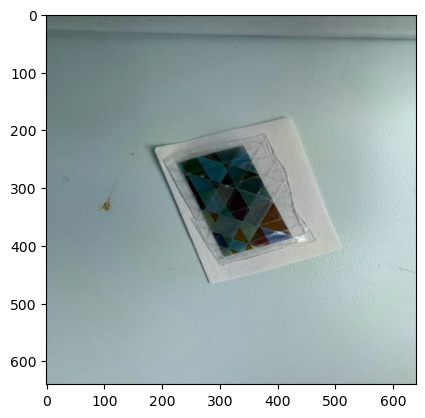

In [36]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()
# cv2.imshow('image', img)